In [1]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GroupShuffleSplit
from sympy.physics.control.control_plots import matplotlib
from tqdm import tqdm


In [2]:
MAIN_DATASET = r"C:\Users\gamer\OneDrive\Desktop\IIT Project\Datasets\datasets\my_dataset\Data_Entry_Final.csv"
OUTPUT_PILOT_DATA_PATH = r"C:\Users\gamer\OneDrive\Desktop\IIT Project\Datasets\datasets\Pilot"
MAIN_IMAGE_PATH = r"C:\Users\gamer\OneDrive\Desktop\IIT Project\Datasets\datasets\nih-chest-xrays\data\versions\3"
IMAGE_RESIZE_PATH_512 = r"C:\Users\gamer\OneDrive\Desktop\IIT Project\Datasets\datasets\Pilot\Image_512"

In [3]:
os.makedirs(OUTPUT_PILOT_DATA_PATH, exist_ok=True)
os.makedirs(IMAGE_RESIZE_PATH_512, exist_ok=True)

In [4]:
TARGET_SIZE = (512, 512)
PILOT_IMAGE_COUNT = 40000
RANDOM_STATE = 42

target_pathologies = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
    'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
    'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
]

minority_classes = ['Cardiomegaly', 'Emphysema', 'Fibrosis', 'Pneumonia', 'Hernia', 'Edema']

In [5]:
df = pd.read_csv(MAIN_DATASET)
df = df[df['Patient Age'] <= 100]
df['is_minority'] = df['Finding Labels'].apply(
    lambda x: any(cls in x for cls in minority_classes)
)

minority_df = df[df['is_minority'] == True]
remaining_df = df[df['is_minority'] == False]
print(f"Total Minority instances available: {len(minority_df)}")
needed = PILOT_IMAGE_COUNT - len(minority_df)

if needed <= 0:
    print("⚠️ Minority samples exceed pilot size. Downsampling minority class.")
    pilot_df = minority_df.sample(
        n=PILOT_IMAGE_COUNT,
        random_state=RANDOM_STATE
    )
else:
    sampled_remaining = remaining_df.sample(
        n=needed,
        random_state=RANDOM_STATE
    )
    pilot_df = pd.concat([minority_df, sampled_remaining])

pilot_df = pilot_df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

print(f"Final Pilot Dataset Size: {len(pilot_df)}")

Total Minority instances available: 10222
Final Pilot Dataset Size: 40000


In [6]:
pilot_csv_path = os.path.join(OUTPUT_PILOT_DATA_PATH, "pilot_data.csv")
pilot_df.to_csv(pilot_csv_path, index=False)

print(f"Pilot CSV saved at: {pilot_csv_path}")

Pilot CSV saved at: C:\Users\gamer\OneDrive\Desktop\IIT Project\Datasets\datasets\Pilot\pilot_data.csv


In [7]:
pilot_csv_path = os.path.join(OUTPUT_PILOT_DATA_PATH, "pilot_data.csv")
print("Loading subset metadata (40k) as pilot_df...")
pilot_df = pd.read_csv(pilot_csv_path)
print("pilot_df shape:", pilot_df.shape)

pilot_df

Loading subset metadata (40k) as pilot_df...
pilot_df shape: (40000, 28)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,ImageWidth,ImageHeight,Pixel(x),...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,is_minority
0,00013695_001.png,No Finding,1,13695,57,F,AP,2500,2048,0.168000,...,0,0,0,0,1,0,0,0,0,False
1,00029394_000.png,No Finding,0,29394,24,M,PA,2021,2021,0.194311,...,0,0,0,0,1,0,0,0,0,False
2,00029982_000.png,No Finding,0,29982,18,M,PA,2021,2021,0.194311,...,0,0,0,0,1,0,0,0,0,False
3,00017138_115.png,Emphysema|Infiltration,115,17138,24,M,AP,2500,2048,0.168000,...,0,0,1,0,0,0,0,0,0,True
4,00025252_024.png,Effusion,24,25252,30,M,AP,3056,2544,0.139000,...,0,0,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,00016175_002.png,Infiltration|Pneumonia,2,16175,9,M,AP,2500,2048,0.168000,...,0,0,1,0,0,0,0,1,0,True
39996,00000362_000.png,No Finding,0,362,63,M,PA,2992,2991,0.143000,...,0,0,0,0,1,0,0,0,0,False
39997,00028895_000.png,Infiltration,0,28895,45,F,PA,2544,3056,0.139000,...,0,0,1,0,0,0,0,0,0,False
39998,00002041_001.png,Emphysema,1,2041,74,F,PA,2464,3056,0.139000,...,0,0,0,0,0,0,0,0,0,True


In [8]:
print(f"Resolving paths across 12 folders and resizing to {TARGET_SIZE}...")

image_location_map = {}
for i in range(1, 13):
    folder_name = f"images_{i:03d}"
    images_subdir = os.path.join(MAIN_IMAGE_PATH, folder_name, "images")
    if os.path.exists(images_subdir):
        for img in os.listdir(images_subdir):
            image_location_map[img] = images_subdir

valid_indices = []

for idx, row in tqdm(pilot_df.iterrows(), total=len(pilot_df)):
    img_name = row['Image Index']
    output_path = os.path.join(IMAGE_RESIZE_PATH_512, img_name)

    # Only skip if this specific image already exists
    if os.path.exists(output_path):
        valid_indices.append(idx)
        continue

    if img_name in image_location_map:
        input_path = os.path.join(image_location_map[img_name], img_name)

        img = cv2.imread(input_path)
        if img is not None:
            resized_img = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)
            cv2.imwrite(output_path, resized_img)
            valid_indices.append(idx)
    else:
        continue


print(f"Valid Indices: {valid_indices}")
pilot_df = pilot_df.loc[valid_indices]
pilot_df

Resolving paths across 12 folders and resizing to (512, 512)...


100%|██████████| 40000/40000 [00:04<00:00, 8600.35it/s]

Valid Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,ImageWidth,ImageHeight,Pixel(x),...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,is_minority
0,00013695_001.png,No Finding,1,13695,57,F,AP,2500,2048,0.168000,...,0,0,0,0,1,0,0,0,0,False
1,00029394_000.png,No Finding,0,29394,24,M,PA,2021,2021,0.194311,...,0,0,0,0,1,0,0,0,0,False
2,00029982_000.png,No Finding,0,29982,18,M,PA,2021,2021,0.194311,...,0,0,0,0,1,0,0,0,0,False
3,00017138_115.png,Emphysema|Infiltration,115,17138,24,M,AP,2500,2048,0.168000,...,0,0,1,0,0,0,0,0,0,True
4,00025252_024.png,Effusion,24,25252,30,M,AP,3056,2544,0.139000,...,0,0,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,00016175_002.png,Infiltration|Pneumonia,2,16175,9,M,AP,2500,2048,0.168000,...,0,0,1,0,0,0,0,1,0,True
39996,00000362_000.png,No Finding,0,362,63,M,PA,2992,2991,0.143000,...,0,0,0,0,1,0,0,0,0,False
39997,00028895_000.png,Infiltration,0,28895,45,F,PA,2544,3056,0.139000,...,0,0,1,0,0,0,0,0,0,False
39998,00002041_001.png,Emphysema,1,2041,74,F,PA,2464,3056,0.139000,...,0,0,0,0,0,0,0,0,0,True


In [10]:
df_pilot = pd.read_csv(pilot_csv_path)

# ---------------- TEST SPLIT (20%) ----------------
gss_test = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_val_idx, test_idx = next(
    gss_test.split(df_pilot, groups=df_pilot['Patient ID'])
)

df_train_val = df_pilot.iloc[train_val_idx]
df_test = df_pilot.iloc[test_idx]

# ---------------- VALIDATION SPLIT (10%) ----------------
gss_val = GroupShuffleSplit(n_splits=1, test_size=0.125, random_state=42)
train_idx, val_idx = next(
    gss_val.split(df_train_val, groups=df_train_val['Patient ID'])
)

df_train = df_train_val.iloc[train_idx]
df_val = df_train_val.iloc[val_idx]


# ---------------- AUDIT ----------------
print("--- Final Clinical Split Audit ---")
print(f"Total Pilot Dataset: {len(df_pilot)} images")
print(f"Training Set:        {len(df_train)} images (Used for learning)")
print(f"Validation Set:      {len(df_val)} images (Used for tuning)")
print(f"Test Set:            {len(df_test)} images (The Final Exam)")
train_pats = set(df_train['Patient ID'])
val_pats = set(df_val['Patient ID'])
test_pats = set(df_test['Patient ID'])

overlap = train_pats.intersection(val_pats) | train_pats.intersection(test_pats) | val_pats.intersection(test_pats)
print(f"Patient Overlap:     {len(overlap)} (Must be 0)")

df_train.to_csv(os.path.join(OUTPUT_PILOT_DATA_PATH, 'train_final.csv'), index=False)
df_val.to_csv(os.path.join(OUTPUT_PILOT_DATA_PATH, 'val_final.csv'), index=False)
df_test.to_csv(os.path.join(OUTPUT_PILOT_DATA_PATH, 'test_final.csv'), index=False)

--- Final Clinical Split Audit ---
Total Pilot Dataset: 40000 images
Training Set:        28080 images (Used for learning)
Validation Set:      3736 images (Used for tuning)
Test Set:            8184 images (The Final Exam)
Patient Overlap:     0 (Must be 0)


In [11]:
def add_multilabel_columns(df, labels):
    for label in labels:
        df[label] = df['FindingsLabels_Strip'].apply(
            lambda x: 1 if label in x else 0
        )
    return df

df_train = df_train.copy()
df_val   = df_val.copy()
df_test  = df_test.copy()

df_train = add_multilabel_columns(df_train, target_pathologies)
df_val   = add_multilabel_columns(df_val, target_pathologies)
df_test  = add_multilabel_columns(df_test, target_pathologies)

print("\n" + "="*40)
print("PREVALENCE REPORT (%)")
print("="*40)

train_prev = (df_train[target_pathologies].mean() * 100).round(2)
test_prev = (df_test[target_pathologies].mean() * 100).round(2)
val_prev = (df_val[target_pathologies].mean() * 100).round(2)

prevalence_df = pd.DataFrame({
    'Train %': train_prev,
    'Val %': val_prev,
    'Test %': test_prev
})

print(prevalence_df)
print("="*40)
print(f"Total Pilot Images Processed: {len(pilot_df)}")


PREVALENCE REPORT (%)
                    Train %  Val %  Test %
Atelectasis           11.08  11.70   10.36
Cardiomegaly           6.86   5.84    7.73
Effusion              14.30  11.83   13.38
Infiltration          19.41  18.63   19.53
Mass                   5.52   5.59    4.78
Nodule                 5.69   5.57    5.62
Pneumonia              3.69   2.70    3.60
Pneumothorax           5.28   5.70    5.77
Consolidation          4.64   4.04    4.59
Edema                  5.88   5.06    5.66
Emphysema              6.31   6.85    5.95
Fibrosis               4.34   3.67    4.03
Pleural_Thickening     3.23   3.53    3.47
Hernia                 0.61   0.37    0.51
Total Pilot Images Processed: 40000


In [12]:
train_df = pd.read_csv(r"C:\Users\gamer\OneDrive\Desktop\IIT Project\Datasets\datasets\Pilot\train_final.csv")
total_samples = len(train_df)

class_counts = {}
for disease in target_pathologies:
    count = train_df['FindingsLabels_Strip'].explode().str.contains(disease).sum()
    class_counts[disease] = count

def calculate_balanced_weights(counts, total):
    weights = {}
    for cls, count in counts.items():
        if count > 0:
            weights[cls] = total / (len(counts) * count)
        else:
            weights[cls] = 1.0 # Fallback
    return weights

pos_weights = calculate_balanced_weights(class_counts, total_samples)

# 5. Professional Report Output
print("="*50)
print(f"{'Pathology':<20} | {'Count':<8} | {'Loss Weight':<10}")
print("="*50)
for disease in target_pathologies:
    print(f"{disease:<20} | {class_counts[disease]:<8} | {pos_weights[disease]:.4f}")
print("="*50)

weight_vector = [pos_weights[d] for d in target_pathologies]
print(f"\nWeight Vector for Model: {np.round(weight_vector, 2).tolist()}")

Pathology            | Count    | Loss Weight
Atelectasis          | 3111     | 0.6447
Cardiomegaly         | 1925     | 1.0419
Effusion             | 4015     | 0.4996
Infiltration         | 5450     | 0.3680
Mass                 | 1550     | 1.2940
Nodule               | 1597     | 1.2559
Pneumonia            | 1035     | 1.9379
Pneumothorax         | 1483     | 1.3525
Consolidation        | 1303     | 1.5393
Edema                | 1651     | 1.2148
Emphysema            | 1773     | 1.1313
Fibrosis             | 1219     | 1.6454
Pleural_Thickening   | 908      | 2.2089
Hernia               | 171      | 11.7293

Weight Vector for Model: [0.64, 1.04, 0.5, 0.37, 1.29, 1.26, 1.94, 1.35, 1.54, 1.21, 1.13, 1.65, 2.21, 11.73]


In [12]:
def remove_artifacts(image):
    """Stage 1: Inpaint corners to remove text/markers (L/R)"""
    mask = np.zeros(image.shape[:2], np.uint8)
    h, w = image.shape[:2]
    # Create 12% corner masks (slightly smaller to be safe)
    mask[0:int(h*0.12), 0:int(w*0.12)] = 255     # Top Left
    mask[0:int(h*0.12), int(w*0.88):w] = 255    # Top Right
    return cv2.inpaint(image, mask, inpaintRadius=3, flags=cv2.INPAINT_NS)

In [13]:
def apply_noise_reduction(image):
    """Stage 2: Hybrid Denoising for Phase 3"""
    # Median blur for digital spikes
    denoised = cv2.medianBlur(image, 3)
    # Gaussian blur for high-frequency equipment noise
    denoised = cv2.GaussianBlur(denoised, (3, 3), 0)
    return denoised

In [14]:
def apply_view_aware_clahe(image, view_position):
    """Stage 3: View-specific contrast enhancement"""
    # AP needs more contrast boost than PA
    clip = 3.0 if view_position == 'AP' else 1.5
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(8,8))
    return clahe.apply(image)

In [15]:
def apply_normalization(image):
    """Stage 4: Phase 3 Z-Score Normalization"""
    img_float = image.astype('float32')
    mean, std = cv2.meanStdDev(img_float)
    # Standardize: (x - mean) / std
    normalized = (img_float - mean[0][0]) / (std[0][0] + 1e-7)

    # Scale back to 0-255 range for saving as PNG
    # Note: For actual training, you would feed the float32 values directly
    final = cv2.normalize(normalized, None, 0, 255, cv2.NORM_MINMAX)
    return final.astype('uint8')

In [16]:
def process_medical_image_full_frame(image_path, view_pos):
    # 1. Load Original (512x512)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return None

    # 2. Step 1: Remove Markers
    img = remove_artifacts(img)

    # 3. Step 2: Noise Reduction (New for Phase 3)
    img = apply_noise_reduction(img)

    # 4. Step 3: View-Aware CLAHE
    img = apply_view_aware_clahe(img, view_pos)

    # 5. Step 4: Normalization (New for Phase 3)
    img = apply_normalization(img)

    return img

In [ ]:
output_dir = os.path.join(OUTPUT_PILOT_DATA_PATH, 'preprocessed_image')
os.makedirs(output_dir, exist_ok=True)

print("🚀 Starting Non-Crop Preprocessing & Phase 3 Normalization...")

for index, row in train_df.iterrows():
    img_name = row['Image Index']
    view = row['View Position']
    input_path = os.path.join(IMAGE_RESIZE_PATH_512, img_name)

    # Use the updated full-frame processor
    processed_img = process_medical_image_full_frame(input_path, view)

    if processed_img is not None:
        cv2.imwrite(os.path.join(output_dir, img_name), processed_img)

    if index % 1000 == 0:
        print(f"✅ Processed {index}/{len(train_df)} images...")

print("✨ Done! Full-frame preprocessed images saved.")

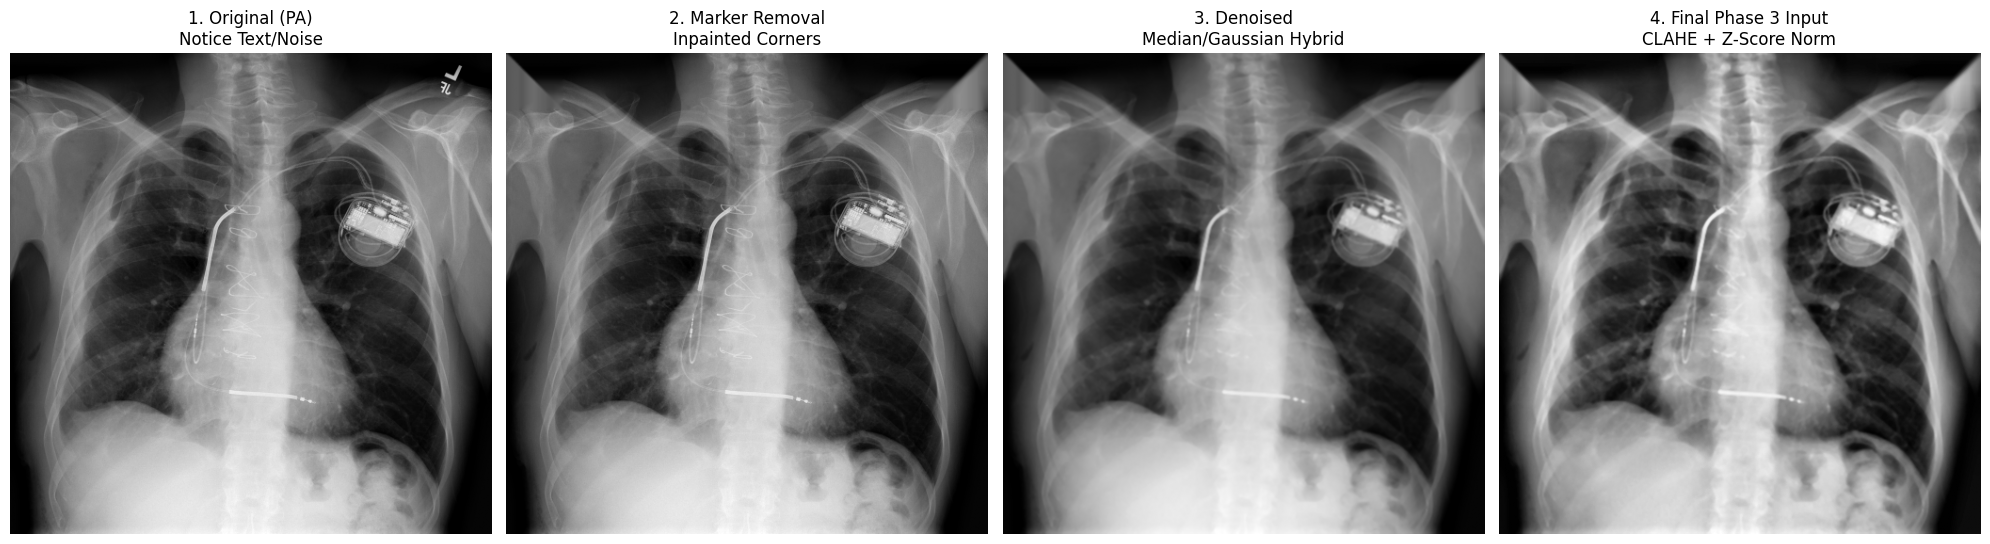

In [18]:
import matplotlib.pyplot as plt
import cv2

def get_preprocessing_preview(image_path, view_pos):
    # 1. Load Original
    original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if original is None:
        print(f"Error: Could not load image at {image_path}")
        return

    # 2. Stage 1: Artifact Removal (Inpainting)
    cleaned = remove_artifacts(original)

    # 3. Stage 2: Noise Reduction (Median + Gaussian)
    denoised = apply_noise_reduction(cleaned)

    # 4. Stage 3 & 4: View-Aware CLAHE + Normalization
    # We combine these as they represent the final "Input Ready" state
    enhanced = apply_view_aware_clahe(denoised, view_pos)
    final = apply_normalization(enhanced)

    # Visualization
    plt.figure(figsize=(20, 10))

    # Plot 1: Original
    plt.subplot(1, 4, 1)
    plt.imshow(original, cmap='gray')
    plt.title(f"1. Original ({view_pos})\nNotice Text/Noise")
    plt.axis('off')

    # Plot 2: Artifact Removal
    plt.subplot(1, 4, 2)
    plt.imshow(cleaned, cmap='gray')
    plt.title("2. Marker Removal\nInpainted Corners")
    plt.axis('off')

    # Plot 3: Noise Reduction
    plt.subplot(1, 4, 3)
    plt.imshow(denoised, cmap='gray')
    plt.title("3. Denoised\nMedian/Gaussian Hybrid")
    plt.axis('off')

    # Plot 4: Final Enhanced & Normalized
    plt.subplot(1, 4, 4)
    plt.imshow(final, cmap='gray')
    plt.title("4. Final Phase 3 Input\nCLAHE + Z-Score Norm")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- RUN PREVIEW ---
# Note: Use a path from your IMAGE_RESIZE_PATH_512 (the 512px source)
# to see the effect from the start of the pipeline.
sample_img_path = r'C:\Users\gamer\OneDrive\Desktop\IIT Project\Datasets\datasets\Pilot\Image_512\00000013_042.png'
sample_view = 'PA'

get_preprocessing_preview(sample_img_path, sample_view)

In [4]:
df_box = pd.read_csv(r'C:\Users\gamer\OneDrive\Desktop\IIT Project\Datasets\datasets\Pilot\train_final.csv')
image_id = "00000910_001.png"

image_boxes = df_box[df_box["Image Index"] == image_id]
image_boxes

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,ImageWidth,ImageHeight,Pixel(x),...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,is_minority
11081,00000910_001.png,Atelectasis|Pneumonia,1,910,56,F,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,1,0,True


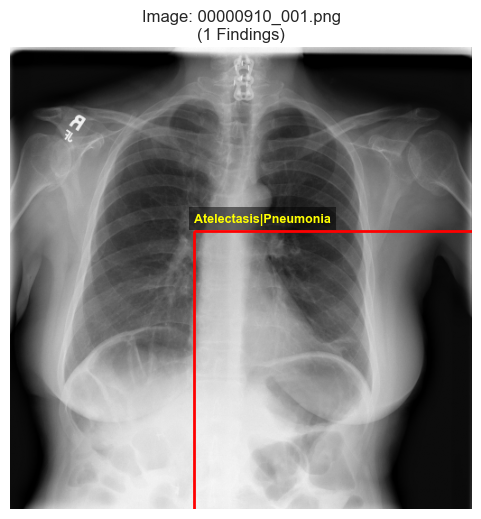

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import os

def show_all_bboxes(image_id):
    # Filter rows for this image
    current_boxes = df_box[df_box["Image Index"] == image_id]

    if current_boxes.empty:
        print(f"No annotations for {image_id}")
        return

    # Image path (dynamic & safe)
    img_path = os.path.join(
        r"C:\Users\gamer\OneDrive\Desktop\IIT Project\Datasets\datasets\Pilot\Image_512",
        image_id
    )

    if not os.path.exists(img_path):
        print(f"Image {image_id} not found.")
        return

    # Load image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img, cmap="gray")

    for _, row in current_boxes.iterrows():

        # Skip healthy images
        if row["Finding Labels"] == "No Finding":
            continue

        img_w = int(row["ImageWidth"])
        img_h = int(row["ImageHeight"])

        # Convert normalized center → pixel center
        x_center = row["Pixel(x)"] * img_w
        y_center = row["Pixel(y)"] * img_h

        # NIH dataset DOES NOT provide bbox size → estimate
        box_w = 0.15 * img_w
        box_h = 0.15 * img_h

        x = x_center - box_w / 2
        y = y_center - box_h / 2

        rect = patches.Rectangle(
            (x, y),
            box_w,
            box_h,
            linewidth=2,
            edgecolor="red",
            facecolor="none"
        )
        ax.add_patch(rect)

        ax.text(
            x,
            max(y - 10, 10),
            row["Finding Labels"],
            color="yellow",
            fontsize=9,
            fontweight="bold",
            bbox=dict(facecolor="black", alpha=0.5, edgecolor="none")
        )

    count = len(current_boxes)
    plt.title(f"Image: {image_id}\n({count} Findings)")
    ax.axis("off")
    plt.show()

show_all_bboxes("00000910_001.png")